<a href="https://colab.research.google.com/github/jahelsantiago/tensorflow_tutorial/blob/master/Creating_Synthetic_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def plot_series(time, series, start = 0, end = None,format = "-", label = None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("serie")
  if label:
        plt.legend(fontsize=14)
  plt.grid(True)

# Trend and Seasonality

In [4]:
def trend(time, slope=0):
    return slope * time

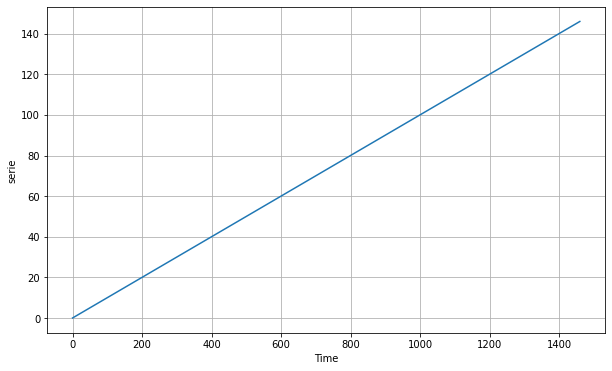

In [13]:
time = np.arange(4*365 + 1)
series = trend(time,0.1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

Generamos una Time Series con Secionalty, o sea que es determinada por ciclos

In [14]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

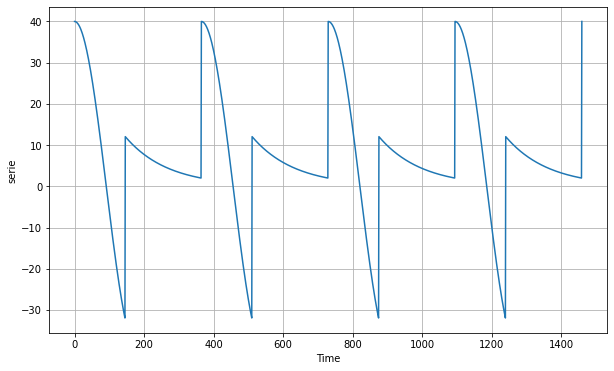

In [15]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Time series with Secionalty and trend

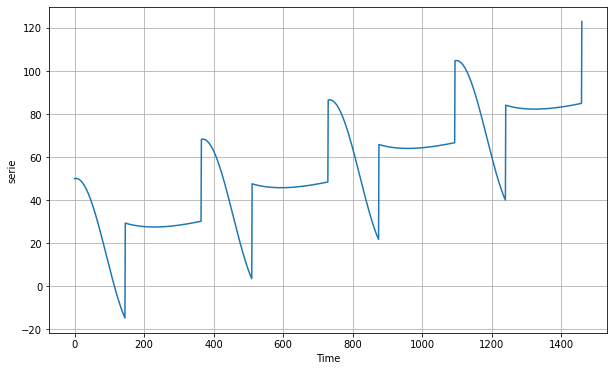

In [16]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Noise, podemos  generar y añadir ruido para hacerlo mas realista

In [18]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

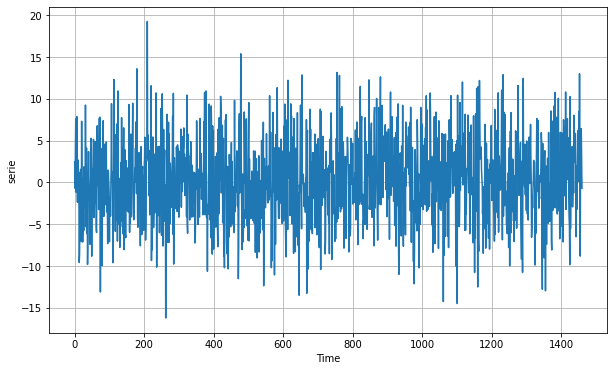

In [19]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

añadimos ruido a la serie

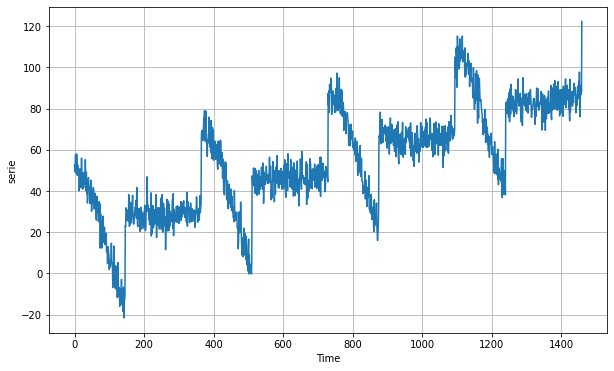

In [20]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Training

### Dividir los datos en train, test y de


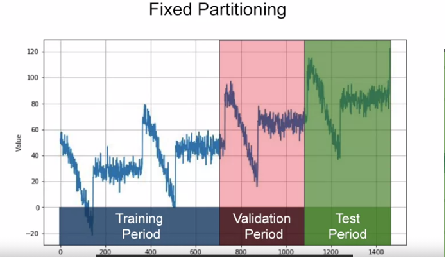

para ello elegimos un punto donde partir los datos y los dividimos en base a eso

In [21]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

en la figura podemos ver como se partieron los datos desde  1000

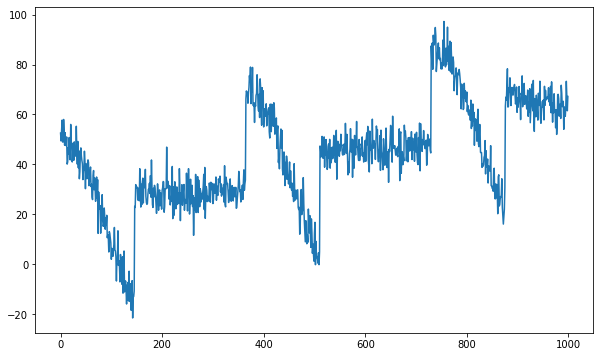

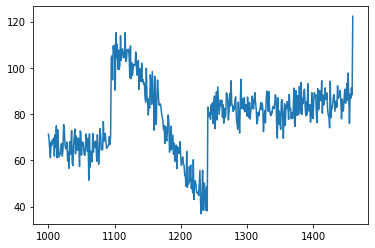

In [26]:
plt.figure(figsize=(10,6))
plt.plot(time_train, x_train)
plt.show()

plt.plot(time_valid, x_valid)
plt.show()

In [22]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [23]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

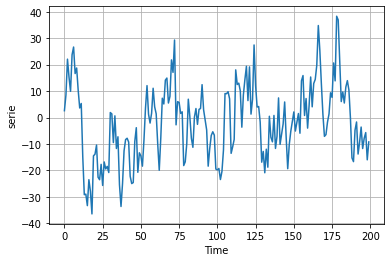

In [24]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()